Try at 05/24/2020

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
from keras.preprocessing.image import ImageDataGenerator, load_img
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import cv2
import random as rn
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [0]:
#setting up path for data
train_path = Path('drive/Shared drives/STA221 - Final Project/datash/train/train')
test_path = Path('drive/Shared drives/STA221 - Final Project/datash/test/test')
normal_data_path = train_path / 'NORMAL'
covid_data_path = train_path / 'COVID19 AND PNEUMONIA'

In [0]:
#get the counts of each type of training data
#https://stackoverflow.com/questions/2632205/how-to-count-the-number-of-files-in-a-directory-using-python
list = os.listdir(normal_data_path)
num_normal = len(list)
print ('Number of normal data in training set:',num_normal)
list2 = os.listdir(covid_data_path)
num_sick = len(list2)
print ('Number of covid data intraining set:',num_sick)

Number of normal data in training set: 1341
Number of covid data intraining set: 3925


In [0]:
list_test = os.listdir(test_path)
num_test = len(list_test)
print ('Number of images in test set:',num_test)

Number of images in test set: 690


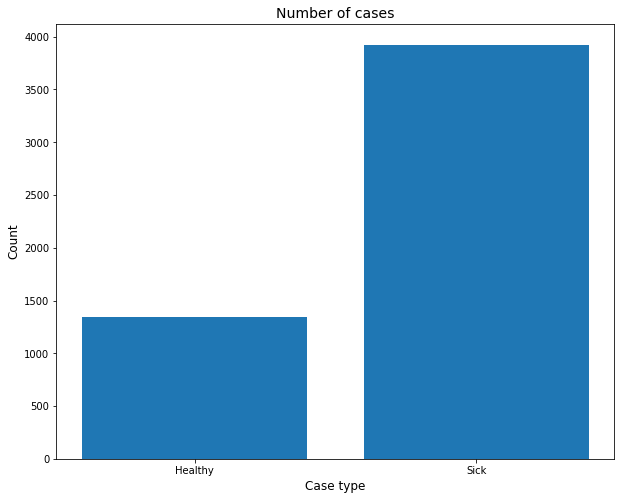

In [0]:
group_names=['Healthy', 'Sick']
cases_count=[num_normal, num_sick]
plt.figure(figsize=(10,8))
pyplot.bar(group_names, cases_count)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
#plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

In [0]:
#resize everything to 150,150 (?)
#check later to see if we can go with other sizes
all_data=[]
all_labels=[]
for img in tqdm(os.listdir(normal_data_path)):
    path = os.path.join(normal_data_path,img)
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (150,150))
    #if img.shape[2] ==1:
    #   img = np.dstack([img, img, img])
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = img.astype(np.float32)/255.
    #label = to_categorical(0, num_classes=2)
    all_data.append(np.array(img))
    all_labels.append(str(0))



100%|██████████| 1341/1341 [26:11<00:00,  1.17s/it]


In [0]:
#resize eveything
for img in tqdm(os.listdir(covid_data_path)):
    path = os.path.join(covid_data_path,img)
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (150,150))
    #if img.shape[2] ==1:
    #   img = np.dstack([img, img, img])
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = img.astype(np.float32)/255.
    #label = to_categorical(0, num_classes=2)
    all_data.append(np.array(img))
    all_labels.append(str(1))

100%|██████████| 3925/3925 [50:55<00:00,  1.28it/s]


In [0]:
all_labels = np.array(all_labels)
all_data = np.array(all_data)

NameError: ignored

In [0]:
#get training and test sets (use .25 as test size)
x_train,x_test,y_train,y_test=train_test_split(all_data,all_labels,test_size=0.25,random_state=42)

In [0]:
len(x_test), len(x_train)

(1317, 3949)

In [0]:
print(x_train.shape,'\n',x_test.shape)

(3949, 150, 150, 3) 
 (1317, 150, 150, 3)


In [0]:
from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [0]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [0]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
from keras.applications.vgg16 import VGG16
base_model=VGG16(include_top=False, weights=None,input_shape=(150,150,3), pooling='avg')

In [0]:
base_model.fit

In [0]:
def build_model():
    input_img = Input(shape=(150,150,3), name='ImageInput')
    # 1st Convolutional Layer
    x = Conv2D(96, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    # Max Pooling
    x = MaxPooling2D((2,2), name='pool1')(x)
    # 2nd Convolutional Layer
    x = Conv2D(256, (3,3), activation='relu', padding='same', name='Conv2')(x)
    # Max Pooling
    x = MaxPooling2D((2,2), name='pool2')(x)
    # 3rd Convolutional Layer
    x = Conv2D(384, (3,3), activation='relu', padding='same', name='Conv3')(x)
    # 4th Convolutional Layer
    x = Conv2D(384, (3,3), activation='relu', padding='same', name='Conv4')(x)
    # 5th Convolutional Layer
    x = Conv2D(384, (3,3), activation='relu', padding='same', name='Conv5')(x)
    # Max Pooling
    x = MaxPooling2D((2,2), name='pool3')(x)
    # Passing it to a Fully Connected layer
    x = Flatten(name='flatten')(x)
    # 1st Fully Connected Layer
    x = Dense(256, activation='relu', name='fc1')(x)
    # Add Dropout to prevent overfitting
    x = Dropout(0.5, name='dropout1')(x)
    # 2nd Fully Connected Layer
    x = Dense(128, activation='relu', name='fc2')(x)
    # Add Dropout
    x = Dropout(0.5, name='dropout2')(x)
    # Output Layer
    x = Dense(1, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [0]:
model=build_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 150, 150, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 150, 150, 128)     3584      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 150, 150, 128)     147584    
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 75, 75, 128)       0         
_________________________________________________________________
Conv3_1 (SeparableConv2D)    (None, 75, 75, 256)       34176     
_________________________________________________________________
bn1 (BatchNormalization)     (None, 75, 75, 256)       1024      
_________________________________________________________________
Conv3_2 (SeparableConv2D)    (None, 75, 75, 256)       6809

In [0]:
#data augmentation?
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [0]:
epochs = 15
batch_size = 20
# learning rate with ADAM
l_r = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=l_r)